# Diffraction-limited Tiger IFU micropupil

*A. Bolton, 2023 Feb*

This notebook implements a toy model for the micropupil image generated by a single square lenslet aperture
of a Tiger-type IFU microlens array in the diffraction limited regime. In this type of IFU,
the micropupil image serves as the spectrograph PSF (after being dispersed and reimaged).
The main motivation is to see if the shape of the micropupil image changes
as the telescope focal-plane PSF is shifted across the lenslet.

**tl;dr: A Tiger IFU will have spatial-spectral degeneracy in the diffraction-limited regime,
unlike in the seeing-limited regime where it will not. So this is probably not a basis for preferring
Tiger over Bigre.**

Why does this happen?

If $\lambda$ is the wavelength of light, $D$ is the primary mirror diameter,
$f$ is the effective focal length of the telescope beam at the microlens array, and $d$ is the physical
size of the IFU lenslet, then the condition for critical sampling of the telescope PSF (of angular scale $\lambda/D$) by the lenslet (subtending an angle $d/f$) is $ d / f \sim \lambda / D $. At the same time, the condition for the pupil image (subtending an angle $D/f$ at the lenslet) to become unresolved by the lenslet
(with angular diffraction limit $\lambda/d$) is $D / f \sim \lambda/d$. These conditions are mathematically the same: $Dd \sim \lambda f$.

### Toy model definition

The simple model is a 6.5m circular aperture with a central obscuration and
three supports, focusing onto a small square aperture of size 40 mas that
we will shift around in the focal plane. The Tiger IFU PSF will be defined by the
far-field pupil emerging from that square aperture. We will use
Fraunhofer mode for simplicity.

The following cells define the model and display the intermediate planes.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import copy

In [2]:
# Model parameters
fl_pri = 3607.5 * u.m  # primary beam focal length (not used in Fraunhofer mode)
diam = 6.5 * u.m       # primary aperture diameter
fs_size = .04          # 40 mas field stop for MLA aperture
fl_mla = 0.0112 * u.m  # focal length of MLA lenslet (not used in Fraunhofer mode)
sec_rad = 0.65*u.m     # secondary radius
n_supp = 3             # number of secondary supports
supp_wid = 0.15*u.m    # width of secondary supports
npix = 1024            # number of pixels across pupil

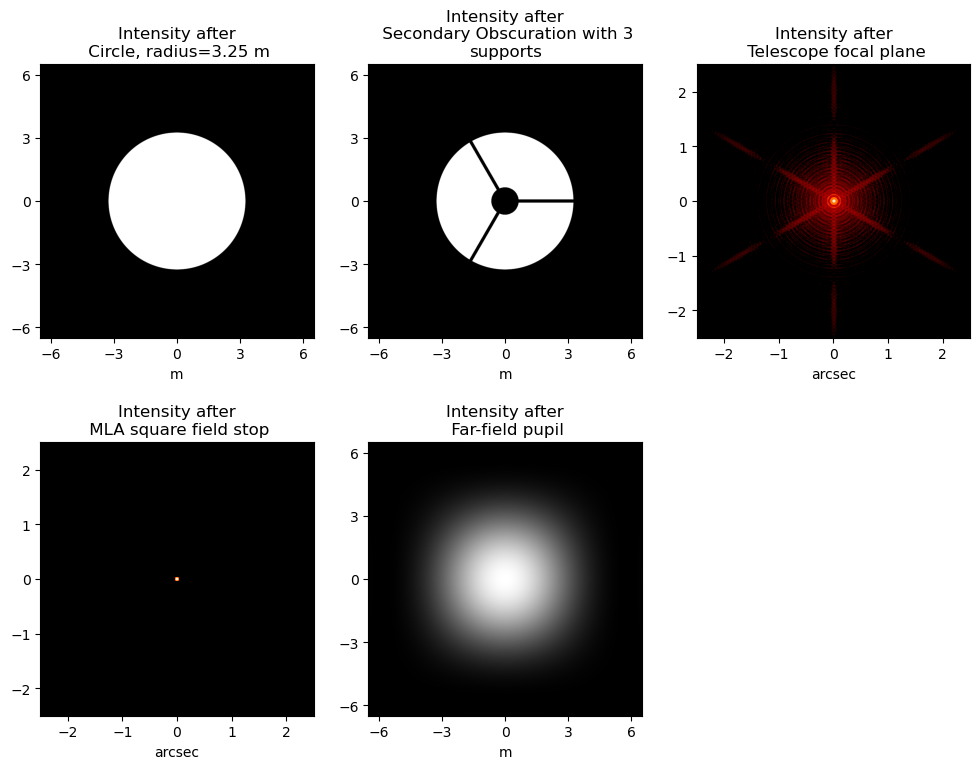

In [3]:
# Display intermediate planes
prim_ap = poppy.CircularAperture(radius=diam.value/2)
sqstop = poppy.SquareFieldStop(size=fs_size, name='MLA square field stop')
#sqstop.shift_x = 0. * fs_size
toy = poppy.OpticalSystem(pupil_diameter=2.*diam.value, npix=npix)
toy.add_pupil(prim_ap)
toy.add_pupil(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
toy.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'))
toy.add_image(sqstop)
toy.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Far-field pupil'))
plt.figure(figsize=(12,9))
psf, waves = toy.calc_psf(wavelength=1.0*u.micron, display_intermediates=True, return_intermediates=True)

### Dependence on position of telescope PSF within lenslet

This next section computes the micropupil PSF for three different wavelengths and
four different values of the shift of the telescope PSF within the lenslet.

The dimensions are arbitrary; the micropupil image will be reimaged with
whatever (de)magnification is appropriate.

The micropupil shape clearly changes as the spectrograph PSF moves within the lenslet (although
this is not readily apparent at the longest wavelength.) This implies that the spectrograph line-spread
function and cross-sectional profile will vary according to the spatial illumination pattern
within the lenslet.

In [4]:
waves = [.4 * u.micron, 1.*u.micron, 1.7*u.micron]
shifts = [0., .25, .5, .75]
psf_array = [[None for i in range(len(waves))] for j in range(len(shifts))]

for j_shift, this_shift in enumerate(shifts):
    #print(this_shift, j_shift)
    prim_ap = poppy.CircularAperture(radius=diam.value/2)
    sqstop = poppy.SquareFieldStop(size=fs_size, name='MLA square field stop')
    sqstop.shift_x = this_shift * fs_size
    toy = poppy.OpticalSystem(pupil_diameter=2.*diam.value, npix=npix)
    toy.add_pupil(prim_ap)
    toy.add_pupil(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
    toy.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'))
    toy.add_image(sqstop)
    toy.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Far-field pupil'))
    for i_wave, this_wave in enumerate(waves):
        #print(this_wave)
        psf = toy.calc_psf(wavelength=this_wave, display_intermediates=False, return_intermediates=False)
        psf_array[j_shift][i_wave] = copy.deepcopy(psf[0].data)

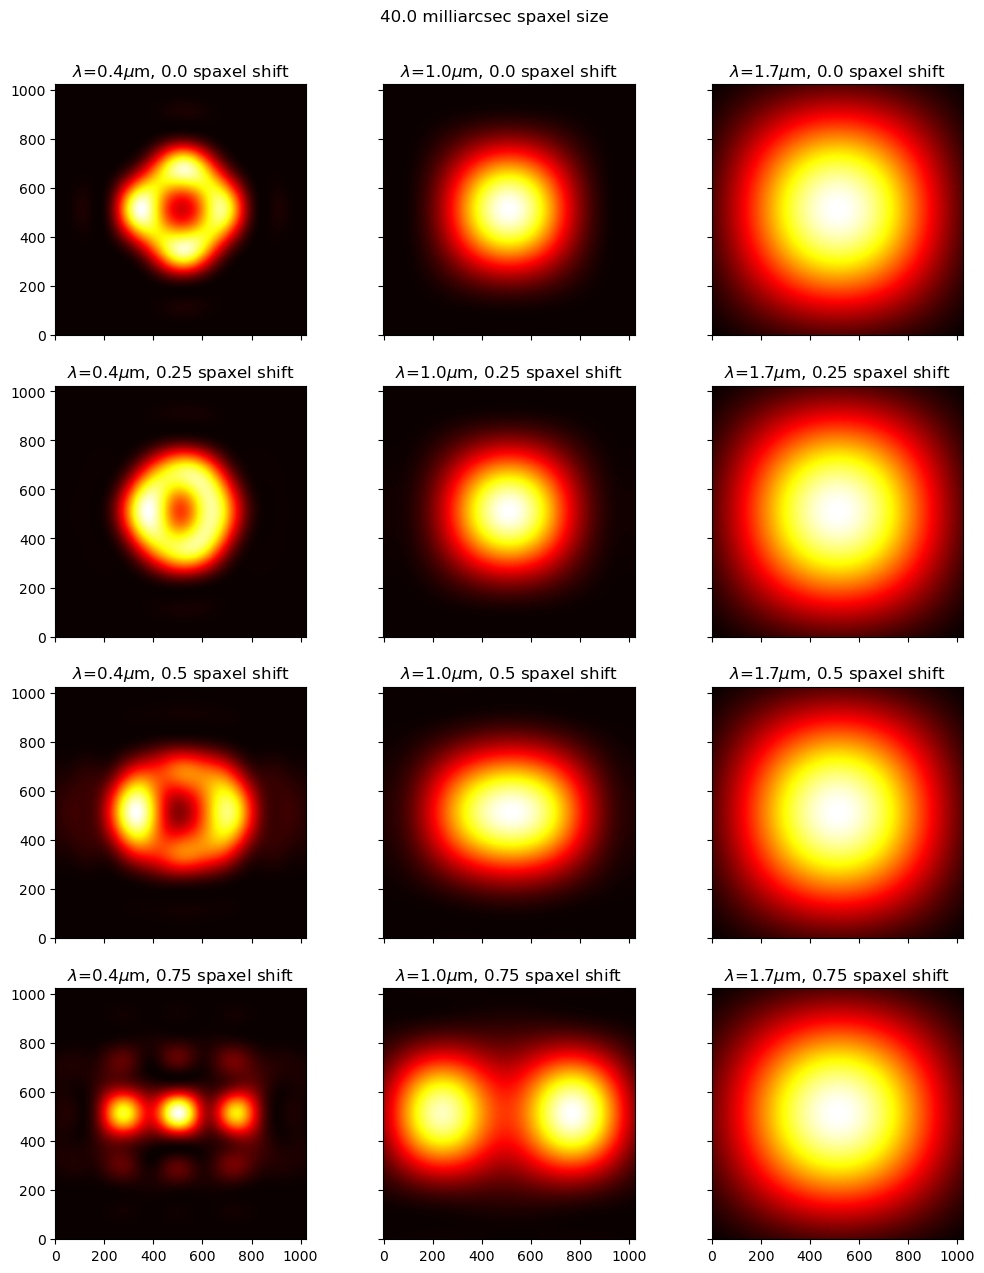

In [5]:
# Make plot
n_w = len(waves)
n_s = len(shifts)
fig, axis = plt.subplots(n_s, n_w, sharex=True, sharey=True)
for i in range(n_w):
    for j in range(n_s):
        axis[j,i].set_box_aspect(1)
        axis[j,i].imshow(psf_array[j][i], cmap='hot', interpolation='none', origin='lower')
        axis[j,i].set_title('$\lambda$='+str(waves[i].value) + '$\mu$m, ' + str(shifts[j])+' spaxel shift')

fig.set_figwidth(12)
fig.set_figheight(15)
junk = fig.suptitle(str(1000 * fs_size) + ' milliarcsec spaxel size', y=.93)

### Dependence on angular size of spaxel / lenslet

The next section keeps the telescope PSF in the center of the lenslet but increases
the lenslet size by a few multiples, for the same three wavelengths as above.

This illustrates the transition to a more recognizable pupil image as the
lenslet gets bigger or the wavelength gets shorter.

In [6]:
waves = [.4 * u.micron, 1.*u.micron, 1.7*u.micron]
scales = [1., 2., 5., 10.]
psf_array = [[None for i in range(len(waves))] for j in range(len(scales))]

for j_scale, this_scale in enumerate(scales):
    prim_ap = poppy.CircularAperture(radius=diam.value/2)
    sqstop = poppy.SquareFieldStop(size=this_scale*fs_size, name='MLA square field stop')
    #sqstop.shift_x = this_shift * fs_size
    toy = poppy.OpticalSystem(pupil_diameter=2.*diam.value, npix=npix)
    toy.add_pupil(prim_ap)
    toy.add_pupil(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
    toy.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'))
    toy.add_image(sqstop)
    toy.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Far-field pupil'))
    for i_wave, this_wave in enumerate(waves):
        psf = toy.calc_psf(wavelength=this_wave, display_intermediates=False, return_intermediates=False)
        psf_array[j_scale][i_wave] = copy.deepcopy(psf[0].data)

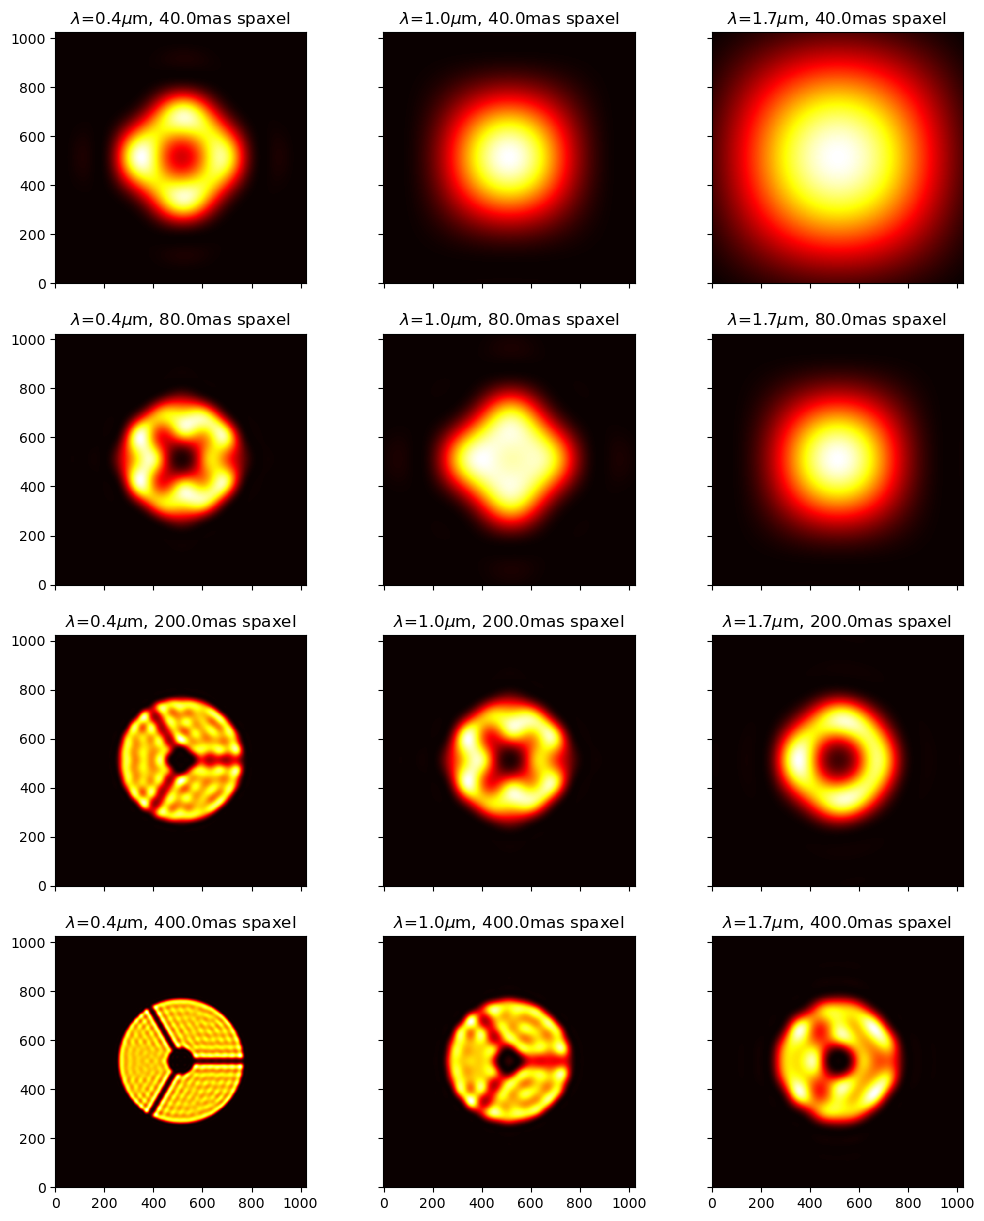

In [7]:
# Make plot
n_w = len(waves)
n_s = len(scales)
fig, axis = plt.subplots(n_s, n_w, sharex=True, sharey=True)
for i in range(n_w):
    for j in range(n_s):
        axis[j,i].set_box_aspect(1)
        axis[j,i].imshow(psf_array[j][i], cmap='hot', interpolation='none', origin='lower')
        axis[j,i].set_title('$\lambda$='+str(waves[i].value) + '$\mu$m, ' + str(scales[j]*fs_size*1000)+'mas spaxel')

fig.set_figwidth(12)
fig.set_figheight(15)